In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
# Sigma function
def sigma(t, k, n):
    a = np.array([])
    for i in range(n):
        for j in range(k):
            a = np.append(a, i+1)
    a = torch.tensor(a, dtype=torch.float32)
    alpha = 16
    return 1 - torch.sigmoid(alpha*(a-t-0.5))

# Tz
class Net(torch.nn.Module):
  def __init__(self, n=4, p=8, noi=1):
    super(Net, self).__init__()
    self.n   = n
    self.p   = p
    self.noi = noi
    self.k   = int(self.p/self.n)
    
    # Branch x0
    self.input_x0  = torch.nn.Linear(1, 8)
    self.hidden_x0 = torch.nn.Linear(8, 8)
    self.output_x0 = torch.nn.Linear(8, self.p)

    # Branch 1 u
    self.input1_u  = torch.nn.Linear(self.noi, 2)
    self.hidden1_u = torch.nn.Linear(2, 2)
    self.output1_u = torch.nn.Linear(2, self.k)

    # Branch 2 u
    self.input2_u  = torch.nn.Linear(self.noi, 2)
    self.hidden2_u = torch.nn.Linear(2, 2)
    self.output2_u = torch.nn.Linear(2, self.k)

    # Branch 3 u
    self.input3_u  = torch.nn.Linear(self.noi, 2)
    self.hidden3_u = torch.nn.Linear(2, 2)
    self.output3_u = torch.nn.Linear(2, self.k)

    # Branch 4 u
    self.input4_u  = torch.nn.Linear(self.noi, 2)
    self.hidden4_u = torch.nn.Linear(2, 2)
    self.output4_u = torch.nn.Linear(2, self.k)

    # Trunk
    self.input_t   = torch.nn.Linear(1, 8)
    self.hidden_t  = torch.nn.Linear(8, 8)
    self.output_t  = torch.nn.Linear(8, self.p)

  def forward(self, x0, u, t):
    # h
    h = torch.relu(self.input_x0(x0))
    h = torch.relu(self.hidden_x0(h))
    h = self.output_x0(h)

    # f
    f1 = torch.relu(self.input1_u(u[:,0:1*self.noi].reshape(-1,self.noi)))
    f1 = torch.relu(self.hidden1_u(f1))
    f1 = self.output1_u(f1)

    f2 = torch.relu(self.input2_u(u[:,1*self.noi:2*self.noi].reshape(-1,self.noi)))
    f2 = torch.relu(self.hidden2_u(f2))
    f2 = self.output2_u(f2)

    f3 = torch.relu(self.input3_u(u[:,2*self.noi:3*self.noi].reshape(-1,self.noi)))
    f3 = torch.relu(self.hidden3_u(f3))
    f3 = self.output3_u(f3)


    f4 = torch.relu(self.input4_u(u[:,3*self.noi:4*self.noi].reshape(-1,self.noi)))
    f4 = torch.relu(self.hidden4_u(f4))
    f4 = self.output4_u(f4)

    f = torch.cat((f1, f2, f3, f4), dim=1)

    # sigma
    s = sigma(t, self.k, self.n)

    # g
    g = torch.relu(self.input_t(t))
    g = torch.relu(self.hidden_t(g))
    g = self.output_t(g)

    return torch.sum(h*f*s*g + x0, dim=1).reshape(-1,1)

Tz_model = Net(n=4, p=8, noi=2)
Tz_model = torch.load('C:/Users/tln229/Downloads/Python/2. DeepONets/0. Saved models/Stacked_conditioned_Tz.pt')

In [3]:
# Read data
df = pd.read_csv('C:/Users/tln229/Downloads/Python/2. DeepONets/0. Data/data_11.csv', header=None)

data = np.array(df.iloc[0])
u_data = data[0:1024]
x_data = data[1024:]

In [4]:
# horizon length
n = 508
x1_pred = np.array([])
x2_pred = np.array([])
x3_pred = np.array([])
x4_pred = np.array([])
for i in range(n):
    with torch.no_grad():
        # COMPUTE
        x0 = torch.tensor(x_data[i].reshape(-1,1), dtype=torch.float32)
        u = torch.tensor(u_data[2*i:2*i+8].reshape(1,-1), dtype=torch.float32)

        t = torch.tensor([[1]], dtype=torch.float32)
        x1 = Tz_model(x0, u, t)

        t = torch.tensor([[2]], dtype=torch.float32)
        x2 = Tz_model(x0, u, t)

        t = torch.tensor([[3]], dtype=torch.float32)
        x3 = Tz_model(x0, u, t)

        t = torch.tensor([[4]], dtype=torch.float32)
        x4 = Tz_model(x0, u, t)

        # save Tz
        x1_pred = np.append(x1_pred, x1.item())
        x2_pred = np.append(x2_pred, x2.item())
        x3_pred = np.append(x3_pred, x3.item())
        x4_pred = np.append(x4_pred, x4.item())

0.9835213177876531


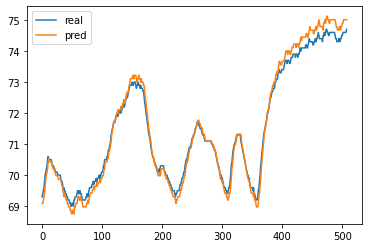

In [5]:
x_true = x_data[1:n+1]
x_pred = x1_pred
print(r2_score(x_true, x_pred))

plt.plot(x_true, label = 'real')
plt.plot(x_pred, label = 'pred')
plt.legend()
plt.show()

0.9735807926570764


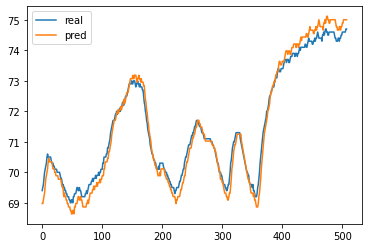

In [6]:
x_true = x_data[2:n+2]
x_pred = x2_pred
print(r2_score(x_true, x_pred))

plt.plot(x_true, label = 'real')
plt.plot(x_pred, label = 'pred')
plt.legend()
plt.show()

0.9615154183820575


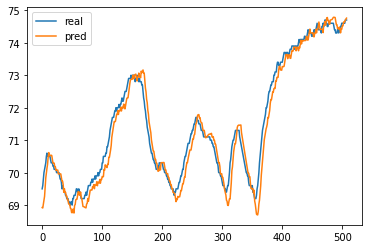

In [7]:
x_true = x_data[3:n+3]
x_pred = x3_pred
print(r2_score(x_true, x_pred))

plt.plot(x_true, label = 'real')
plt.plot(x_pred, label = 'pred')
plt.legend()
plt.show()

0.9528702252069567


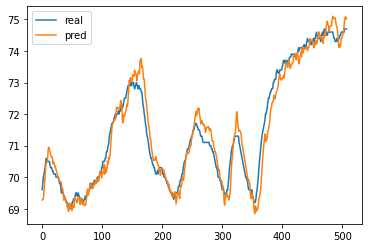

In [8]:
x_true = x_data[4:n+4]
x_pred = x4_pred
print(r2_score(x_true, x_pred))

plt.plot(x_true, label = 'real')
plt.plot(x_pred, label = 'pred')
plt.legend()
plt.show()